# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

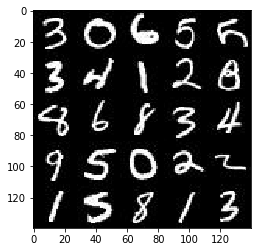

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[25:25+show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

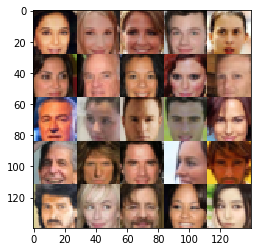

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "real_images")
    z = tf.placeholder(tf.float32, [None, z_dim], "z")
    learning_rate = tf.placeholder(tf.float32, name="learning_reate")
    return real_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    filters = 32
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        
        # 28x28x3
        x1 = tf.layers.conv2d(images, filters, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 14x14x64
        x2 = tf.layers.conv2d(relu1, filters * 2, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 7x7x128
        x3 = tf.layers.conv2d(relu2, filters * 4, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # 4x4x256       
        flat = tf.reshape(relu3, (-1, 4*4*filters*4))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    size_mult = 512
    with tf.variable_scope("generator", reuse=not is_train):
        
        # z-dim
        x1 = tf.layers.dense(z, 7 * 7 * size_mult * 2)     
        x1 = tf.reshape(x1, [-1, 7, 7, size_mult * 2])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4xsize_mult * 4
        # print(x1.get_shape())
        
        # x2 = tf.layers.conv2d_transpose(x1, size_mult * 2, 4, strides=1, padding='valid')
        # x2 = tf.layers.batch_normalization(x2, training=is_train)
        # x2 = tf.maximum(alpha * x2, x2)        
        # 8x8xsize_mult * 2
        # print(x2.get_shape())
        
        x3 = tf.layers.conv2d_transpose(x1, size_mult, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16xsize_mult * 4
        # print(x3.get_shape())
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32xout_channel_dim
        # print(logits.get_shape())
        
        # logits = tf.image.crop_to_bounding_box(logits, 2, 2, 28, 28)
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real =tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # unzip tuple
    image_count, image_width, image_height, image_channels = data_shape
    
    # get input placeholders
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # get loss variables
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # get opt variables
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    steps = 0
    show_every = 100
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # scale to -1.0 to 1.0 (from -0.5 to 0.5)
                batch_images = batch_images * 2.0
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                # Run generator twice
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
        
        print("Finished training")
        show_generator_output(sess, 25, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4205... Generator Loss: 1.6516
Epoch 1/2... Discriminator Loss: 2.1970... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 2.5611... Generator Loss: 0.2193
Epoch 1/2... Discriminator Loss: 2.2974... Generator Loss: 0.2672
Epoch 1/2... Discriminator Loss: 1.8822... Generator Loss: 0.5140
Epoch 1/2... Discriminator Loss: 1.8202... Generator Loss: 0.5024
Epoch 1/2... Discriminator Loss: 1.8308... Generator Loss: 0.4008
Epoch 1/2... Discriminator Loss: 1.6971... Generator Loss: 0.3515
Epoch 1/2... Discriminator Loss: 1.6519... Generator Loss: 0.4447
Epoch 1/2... Discriminator Loss: 1.9479... Generator Loss: 0.4517


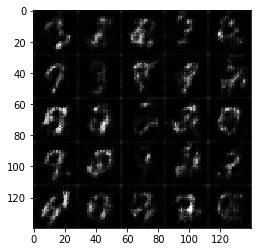

Epoch 1/2... Discriminator Loss: 2.1970... Generator Loss: 0.2813
Epoch 1/2... Discriminator Loss: 1.7985... Generator Loss: 0.3066
Epoch 1/2... Discriminator Loss: 1.8567... Generator Loss: 0.2676
Epoch 1/2... Discriminator Loss: 1.6756... Generator Loss: 0.4874
Epoch 1/2... Discriminator Loss: 1.5195... Generator Loss: 0.6107
Epoch 1/2... Discriminator Loss: 1.5928... Generator Loss: 0.5140
Epoch 1/2... Discriminator Loss: 1.7616... Generator Loss: 0.4583
Epoch 1/2... Discriminator Loss: 1.6052... Generator Loss: 0.5546
Epoch 1/2... Discriminator Loss: 1.9654... Generator Loss: 0.2844
Epoch 1/2... Discriminator Loss: 1.8412... Generator Loss: 0.3140


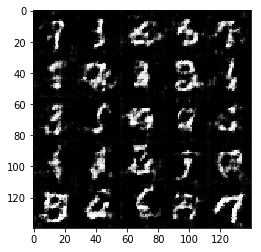

Epoch 1/2... Discriminator Loss: 1.7388... Generator Loss: 0.5995
Epoch 1/2... Discriminator Loss: 1.7382... Generator Loss: 0.3743
Epoch 1/2... Discriminator Loss: 1.6236... Generator Loss: 0.3912
Epoch 1/2... Discriminator Loss: 1.8863... Generator Loss: 0.2390
Epoch 1/2... Discriminator Loss: 1.8702... Generator Loss: 0.2756
Epoch 1/2... Discriminator Loss: 1.7199... Generator Loss: 0.5435
Epoch 1/2... Discriminator Loss: 1.6839... Generator Loss: 0.6652
Epoch 1/2... Discriminator Loss: 1.8667... Generator Loss: 0.3056
Epoch 1/2... Discriminator Loss: 1.6266... Generator Loss: 0.4060
Epoch 1/2... Discriminator Loss: 2.1376... Generator Loss: 0.1685


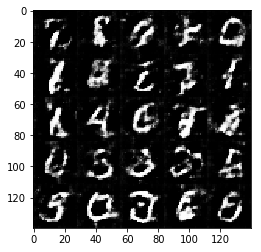

Epoch 1/2... Discriminator Loss: 1.6437... Generator Loss: 0.3966
Epoch 1/2... Discriminator Loss: 1.7221... Generator Loss: 0.3236
Epoch 1/2... Discriminator Loss: 1.5776... Generator Loss: 0.4120
Epoch 1/2... Discriminator Loss: 1.5655... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 1.6407... Generator Loss: 0.5874
Epoch 1/2... Discriminator Loss: 1.8614... Generator Loss: 0.2311
Epoch 1/2... Discriminator Loss: 1.6564... Generator Loss: 0.8257
Epoch 1/2... Discriminator Loss: 1.6748... Generator Loss: 0.5223
Epoch 1/2... Discriminator Loss: 2.1948... Generator Loss: 0.1453
Epoch 1/2... Discriminator Loss: 1.6176... Generator Loss: 0.4052


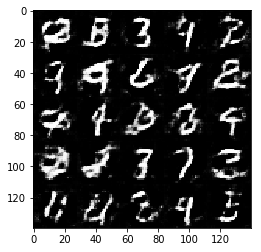

Epoch 1/2... Discriminator Loss: 1.5435... Generator Loss: 0.4137
Epoch 1/2... Discriminator Loss: 1.9863... Generator Loss: 0.2062
Epoch 1/2... Discriminator Loss: 1.9373... Generator Loss: 0.2287
Epoch 1/2... Discriminator Loss: 1.5469... Generator Loss: 0.8414
Epoch 1/2... Discriminator Loss: 2.2668... Generator Loss: 0.1391
Epoch 1/2... Discriminator Loss: 1.7604... Generator Loss: 0.3646
Epoch 1/2... Discriminator Loss: 2.0038... Generator Loss: 0.1946
Epoch 1/2... Discriminator Loss: 1.5062... Generator Loss: 0.4517
Epoch 1/2... Discriminator Loss: 1.8131... Generator Loss: 0.2792
Epoch 1/2... Discriminator Loss: 1.6904... Generator Loss: 0.3507


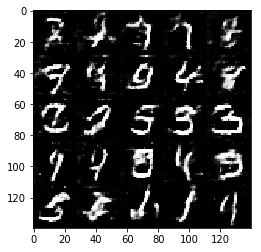

Epoch 1/2... Discriminator Loss: 1.5012... Generator Loss: 0.5453
Epoch 1/2... Discriminator Loss: 1.6498... Generator Loss: 0.3575
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.3986
Epoch 1/2... Discriminator Loss: 1.6954... Generator Loss: 0.3432
Epoch 1/2... Discriminator Loss: 1.5798... Generator Loss: 0.7997
Epoch 1/2... Discriminator Loss: 1.5667... Generator Loss: 0.5248
Epoch 1/2... Discriminator Loss: 2.0037... Generator Loss: 0.1862
Epoch 1/2... Discriminator Loss: 1.5782... Generator Loss: 0.5071
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 0.7408
Epoch 1/2... Discriminator Loss: 1.4614... Generator Loss: 0.4565


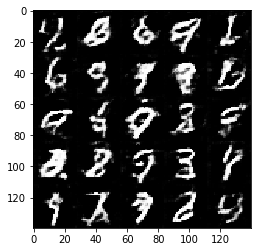

Epoch 1/2... Discriminator Loss: 1.4498... Generator Loss: 0.5694
Epoch 1/2... Discriminator Loss: 1.7839... Generator Loss: 0.2535
Epoch 1/2... Discriminator Loss: 1.6408... Generator Loss: 0.2931
Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.6521
Epoch 1/2... Discriminator Loss: 2.0238... Generator Loss: 0.2049
Epoch 1/2... Discriminator Loss: 1.7054... Generator Loss: 0.3420
Epoch 1/2... Discriminator Loss: 1.6310... Generator Loss: 0.4154
Epoch 1/2... Discriminator Loss: 1.4659... Generator Loss: 0.5201
Epoch 1/2... Discriminator Loss: 1.6463... Generator Loss: 0.3120
Epoch 1/2... Discriminator Loss: 1.7329... Generator Loss: 0.3743


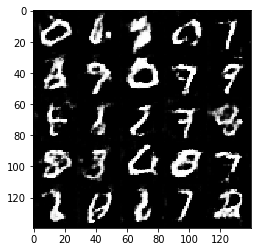

Epoch 1/2... Discriminator Loss: 1.4855... Generator Loss: 0.5141
Epoch 1/2... Discriminator Loss: 1.9473... Generator Loss: 0.1986
Epoch 1/2... Discriminator Loss: 1.5966... Generator Loss: 0.3548
Epoch 1/2... Discriminator Loss: 1.5230... Generator Loss: 0.4039
Epoch 1/2... Discriminator Loss: 2.2149... Generator Loss: 0.1378
Epoch 1/2... Discriminator Loss: 1.9731... Generator Loss: 0.1907
Epoch 1/2... Discriminator Loss: 1.5365... Generator Loss: 0.5288
Epoch 1/2... Discriminator Loss: 1.6275... Generator Loss: 0.4715
Epoch 1/2... Discriminator Loss: 1.5877... Generator Loss: 0.4791
Epoch 1/2... Discriminator Loss: 1.6513... Generator Loss: 0.3079


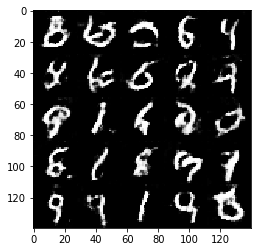

Epoch 1/2... Discriminator Loss: 1.5703... Generator Loss: 0.3685
Epoch 1/2... Discriminator Loss: 1.4424... Generator Loss: 0.3860
Epoch 1/2... Discriminator Loss: 2.4708... Generator Loss: 0.1092
Epoch 1/2... Discriminator Loss: 1.5672... Generator Loss: 0.4628
Epoch 1/2... Discriminator Loss: 2.5840... Generator Loss: 0.1001
Epoch 1/2... Discriminator Loss: 1.6041... Generator Loss: 0.4059
Epoch 1/2... Discriminator Loss: 1.4061... Generator Loss: 0.4562
Epoch 1/2... Discriminator Loss: 2.1030... Generator Loss: 0.1581
Epoch 1/2... Discriminator Loss: 1.4844... Generator Loss: 0.4339
Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 0.4703


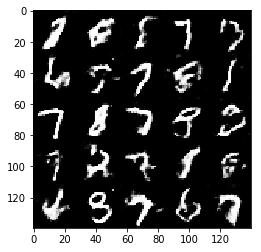

Epoch 1/2... Discriminator Loss: 1.6494... Generator Loss: 0.3568
Epoch 1/2... Discriminator Loss: 1.5504... Generator Loss: 0.3713
Epoch 1/2... Discriminator Loss: 2.0061... Generator Loss: 0.1857
Epoch 1/2... Discriminator Loss: 1.4250... Generator Loss: 0.5386
Epoch 1/2... Discriminator Loss: 1.5712... Generator Loss: 0.5343
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.5484
Epoch 1/2... Discriminator Loss: 2.1108... Generator Loss: 0.1569
Epoch 1/2... Discriminator Loss: 1.7882... Generator Loss: 0.4521
Epoch 1/2... Discriminator Loss: 2.3202... Generator Loss: 0.1265
Epoch 1/2... Discriminator Loss: 1.5812... Generator Loss: 0.3590


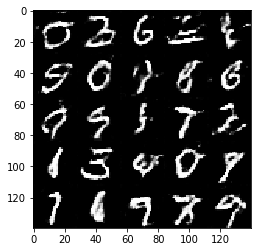

Epoch 1/2... Discriminator Loss: 1.6813... Generator Loss: 0.2691
Epoch 1/2... Discriminator Loss: 1.7876... Generator Loss: 0.2342
Epoch 1/2... Discriminator Loss: 1.8114... Generator Loss: 0.2775
Epoch 1/2... Discriminator Loss: 1.4755... Generator Loss: 0.5944
Epoch 1/2... Discriminator Loss: 2.2312... Generator Loss: 0.1436
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 1.0540... Generator Loss: 0.9378
Epoch 1/2... Discriminator Loss: 2.1222... Generator Loss: 0.1670
Epoch 1/2... Discriminator Loss: 1.8205... Generator Loss: 0.3171
Epoch 1/2... Discriminator Loss: 1.5837... Generator Loss: 0.5922


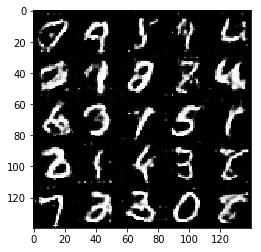

Epoch 1/2... Discriminator Loss: 1.3000... Generator Loss: 0.6349
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.5257
Epoch 1/2... Discriminator Loss: 2.5896... Generator Loss: 0.1012
Epoch 1/2... Discriminator Loss: 1.4348... Generator Loss: 0.4036
Epoch 1/2... Discriminator Loss: 2.2730... Generator Loss: 0.1563
Epoch 1/2... Discriminator Loss: 1.5405... Generator Loss: 0.6169
Epoch 1/2... Discriminator Loss: 1.6337... Generator Loss: 0.4691
Epoch 1/2... Discriminator Loss: 1.8261... Generator Loss: 0.3259
Epoch 1/2... Discriminator Loss: 1.9843... Generator Loss: 0.2416
Epoch 1/2... Discriminator Loss: 1.8235... Generator Loss: 0.2394


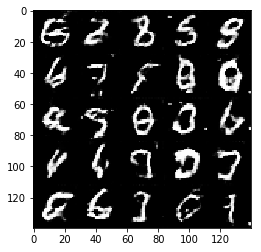

Epoch 1/2... Discriminator Loss: 1.7108... Generator Loss: 0.2895
Epoch 1/2... Discriminator Loss: 1.9206... Generator Loss: 0.2241
Epoch 1/2... Discriminator Loss: 1.7789... Generator Loss: 0.2604
Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 0.4981
Epoch 1/2... Discriminator Loss: 2.1162... Generator Loss: 0.1873
Epoch 1/2... Discriminator Loss: 1.7566... Generator Loss: 0.2585
Epoch 1/2... Discriminator Loss: 1.5248... Generator Loss: 0.4423
Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 0.7906
Epoch 1/2... Discriminator Loss: 2.6406... Generator Loss: 0.1213
Epoch 1/2... Discriminator Loss: 1.4320... Generator Loss: 0.4415


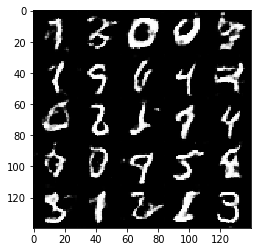

Epoch 1/2... Discriminator Loss: 1.9506... Generator Loss: 0.2238
Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 0.4323
Epoch 1/2... Discriminator Loss: 2.6133... Generator Loss: 0.1122
Epoch 1/2... Discriminator Loss: 2.0614... Generator Loss: 0.1939
Epoch 1/2... Discriminator Loss: 2.2062... Generator Loss: 0.1629
Epoch 1/2... Discriminator Loss: 1.8873... Generator Loss: 0.2086
Epoch 1/2... Discriminator Loss: 1.8506... Generator Loss: 0.2631
Epoch 1/2... Discriminator Loss: 1.5329... Generator Loss: 0.3352
Epoch 1/2... Discriminator Loss: 1.6183... Generator Loss: 0.3075
Epoch 1/2... Discriminator Loss: 1.4424... Generator Loss: 0.3941


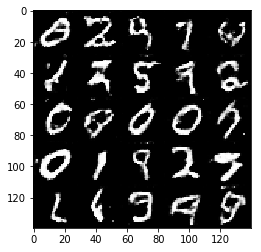

Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 1.0985
Epoch 1/2... Discriminator Loss: 1.5526... Generator Loss: 0.3190
Epoch 1/2... Discriminator Loss: 1.3006... Generator Loss: 1.9240
Epoch 1/2... Discriminator Loss: 2.0359... Generator Loss: 0.1860
Epoch 1/2... Discriminator Loss: 3.2663... Generator Loss: 0.0575
Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 0.4285
Epoch 1/2... Discriminator Loss: 1.6976... Generator Loss: 0.2929
Epoch 1/2... Discriminator Loss: 1.9369... Generator Loss: 0.2271
Epoch 1/2... Discriminator Loss: 2.0346... Generator Loss: 0.2323
Epoch 1/2... Discriminator Loss: 1.4728... Generator Loss: 0.3778


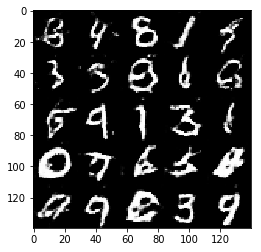

Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 1.7286
Epoch 1/2... Discriminator Loss: 1.5148... Generator Loss: 0.4015
Epoch 1/2... Discriminator Loss: 1.9401... Generator Loss: 0.2406
Epoch 1/2... Discriminator Loss: 1.7107... Generator Loss: 0.3060
Epoch 1/2... Discriminator Loss: 1.6332... Generator Loss: 0.3418
Epoch 1/2... Discriminator Loss: 0.9352... Generator Loss: 0.8056
Epoch 1/2... Discriminator Loss: 1.0743... Generator Loss: 0.9180
Epoch 1/2... Discriminator Loss: 1.6817... Generator Loss: 0.3138
Epoch 1/2... Discriminator Loss: 2.1286... Generator Loss: 0.2239
Epoch 1/2... Discriminator Loss: 1.4884... Generator Loss: 0.5006


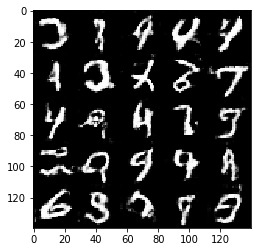

Epoch 1/2... Discriminator Loss: 1.6677... Generator Loss: 0.2752
Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 1.4538... Generator Loss: 0.4205
Epoch 1/2... Discriminator Loss: 1.5792... Generator Loss: 0.3392
Epoch 1/2... Discriminator Loss: 1.4385... Generator Loss: 0.4499
Epoch 1/2... Discriminator Loss: 2.5071... Generator Loss: 0.1214
Epoch 1/2... Discriminator Loss: 1.7878... Generator Loss: 0.2929
Epoch 1/2... Discriminator Loss: 1.5036... Generator Loss: 0.3221
Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 0.5828
Epoch 1/2... Discriminator Loss: 1.5465... Generator Loss: 0.3792


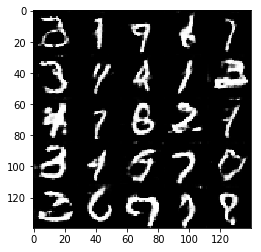

Epoch 1/2... Discriminator Loss: 3.2216... Generator Loss: 0.0807
Epoch 1/2... Discriminator Loss: 2.1278... Generator Loss: 0.2024
Epoch 1/2... Discriminator Loss: 1.3583... Generator Loss: 0.3977
Epoch 1/2... Discriminator Loss: 1.6364... Generator Loss: 0.2917
Epoch 1/2... Discriminator Loss: 1.6243... Generator Loss: 0.2967
Epoch 1/2... Discriminator Loss: 1.7368... Generator Loss: 2.6845
Epoch 1/2... Discriminator Loss: 1.2075... Generator Loss: 0.5081
Epoch 1/2... Discriminator Loss: 2.4254... Generator Loss: 0.1316
Epoch 1/2... Discriminator Loss: 1.8850... Generator Loss: 0.2324
Epoch 1/2... Discriminator Loss: 2.4895... Generator Loss: 0.1602


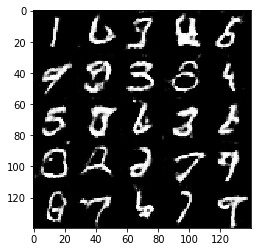

Epoch 1/2... Discriminator Loss: 2.1298... Generator Loss: 0.2740
Epoch 1/2... Discriminator Loss: 2.3736... Generator Loss: 0.1421
Epoch 1/2... Discriminator Loss: 1.4776... Generator Loss: 0.4134
Epoch 1/2... Discriminator Loss: 1.6615... Generator Loss: 0.2937
Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 0.6231
Epoch 1/2... Discriminator Loss: 1.6119... Generator Loss: 0.3720
Epoch 1/2... Discriminator Loss: 2.3405... Generator Loss: 0.1593
Epoch 2/2... Discriminator Loss: 1.0853... Generator Loss: 0.5925
Epoch 2/2... Discriminator Loss: 2.5353... Generator Loss: 0.1120
Epoch 2/2... Discriminator Loss: 1.5959... Generator Loss: 0.6562


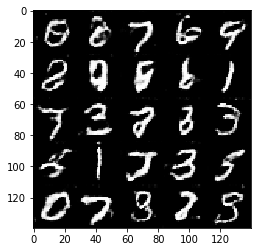

Epoch 2/2... Discriminator Loss: 0.8396... Generator Loss: 0.9536
Epoch 2/2... Discriminator Loss: 0.9758... Generator Loss: 1.0889
Epoch 2/2... Discriminator Loss: 1.3709... Generator Loss: 0.5052
Epoch 2/2... Discriminator Loss: 1.2370... Generator Loss: 0.5281
Epoch 2/2... Discriminator Loss: 1.1032... Generator Loss: 0.9455
Epoch 2/2... Discriminator Loss: 1.2136... Generator Loss: 0.6084
Epoch 2/2... Discriminator Loss: 2.0300... Generator Loss: 0.1954
Epoch 2/2... Discriminator Loss: 1.7801... Generator Loss: 0.2979
Epoch 2/2... Discriminator Loss: 2.0243... Generator Loss: 0.2414
Epoch 2/2... Discriminator Loss: 2.3181... Generator Loss: 0.1365


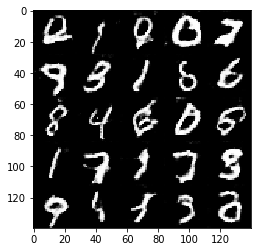

Epoch 2/2... Discriminator Loss: 1.0316... Generator Loss: 0.7919
Epoch 2/2... Discriminator Loss: 1.6290... Generator Loss: 0.3724
Epoch 2/2... Discriminator Loss: 0.6232... Generator Loss: 1.1265
Epoch 2/2... Discriminator Loss: 0.8805... Generator Loss: 0.9902
Epoch 2/2... Discriminator Loss: 1.5006... Generator Loss: 0.5073
Epoch 2/2... Discriminator Loss: 1.4777... Generator Loss: 0.4420
Epoch 2/2... Discriminator Loss: 1.6679... Generator Loss: 0.3869
Epoch 2/2... Discriminator Loss: 1.7934... Generator Loss: 0.3068
Epoch 2/2... Discriminator Loss: 1.4482... Generator Loss: 0.3677
Epoch 2/2... Discriminator Loss: 2.4113... Generator Loss: 0.1352


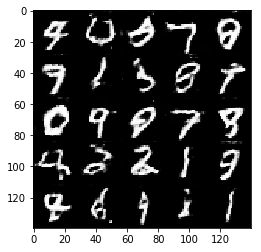

Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 2.2467... Generator Loss: 0.1662
Epoch 2/2... Discriminator Loss: 1.6592... Generator Loss: 0.2782
Epoch 2/2... Discriminator Loss: 1.7566... Generator Loss: 0.3078
Epoch 2/2... Discriminator Loss: 1.6175... Generator Loss: 0.3710
Epoch 2/2... Discriminator Loss: 1.4900... Generator Loss: 0.3973
Epoch 2/2... Discriminator Loss: 2.6183... Generator Loss: 0.1056
Epoch 2/2... Discriminator Loss: 1.9966... Generator Loss: 0.2733
Epoch 2/2... Discriminator Loss: 1.1298... Generator Loss: 0.7273
Epoch 2/2... Discriminator Loss: 1.9366... Generator Loss: 0.3080


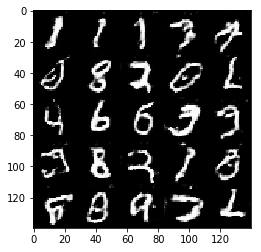

Epoch 2/2... Discriminator Loss: 2.1112... Generator Loss: 0.2033
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.4839
Epoch 2/2... Discriminator Loss: 1.9082... Generator Loss: 0.2941
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 0.6682
Epoch 2/2... Discriminator Loss: 0.9787... Generator Loss: 1.8432


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.8685... Generator Loss: 0.0650
Epoch 1/1... Discriminator Loss: 3.8962... Generator Loss: 0.0385
Epoch 1/1... Discriminator Loss: 2.5986... Generator Loss: 0.4725
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 2.0772... Generator Loss: 0.5126
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.4209
Epoch 1/1... Discriminator Loss: 1.8924... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 2.2279... Generator Loss: 0.2622
Epoch 1/1... Discriminator Loss: 2.1100... Generator Loss: 0.2521
Epoch 1/1... Discriminator Loss: 2.0256... Generator Loss: 0.3712


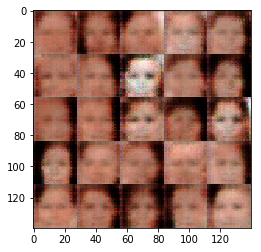

Epoch 1/1... Discriminator Loss: 1.8737... Generator Loss: 0.3528
Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 1.7802
Epoch 1/1... Discriminator Loss: 1.6528... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.7729... Generator Loss: 0.3528
Epoch 1/1... Discriminator Loss: 2.0191... Generator Loss: 0.2376
Epoch 1/1... Discriminator Loss: 1.8780... Generator Loss: 0.2987
Epoch 1/1... Discriminator Loss: 1.7656... Generator Loss: 0.3600
Epoch 1/1... Discriminator Loss: 2.5617... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 1.6933... Generator Loss: 0.3238


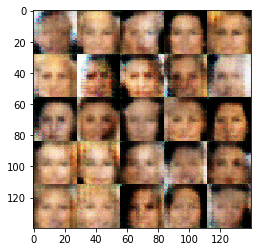

Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.6096... Generator Loss: 0.3750
Epoch 1/1... Discriminator Loss: 1.7314... Generator Loss: 0.3195
Epoch 1/1... Discriminator Loss: 1.9933... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.8743... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.5756... Generator Loss: 1.1906
Epoch 1/1... Discriminator Loss: 1.7985... Generator Loss: 0.4230
Epoch 1/1... Discriminator Loss: 1.7191... Generator Loss: 0.4173
Epoch 1/1... Discriminator Loss: 1.7029... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.8876


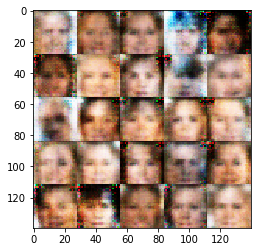

Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.5647
Epoch 1/1... Discriminator Loss: 1.7220... Generator Loss: 0.4031
Epoch 1/1... Discriminator Loss: 1.6740... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.6062... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 1.5756... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.6346... Generator Loss: 0.3718


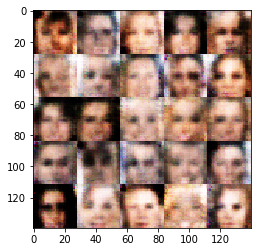

Epoch 1/1... Discriminator Loss: 1.5508... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.6818... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.6909... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.6804... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.6015... Generator Loss: 0.4743
Epoch 1/1... Discriminator Loss: 1.5853... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.6120... Generator Loss: 0.6760


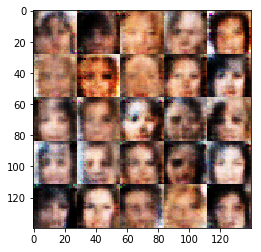

Epoch 1/1... Discriminator Loss: 1.6228... Generator Loss: 0.4225
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.8312... Generator Loss: 0.2960
Epoch 1/1... Discriminator Loss: 1.5962... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.8433... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 1.7939... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.7952... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 1.6662... Generator Loss: 0.5060


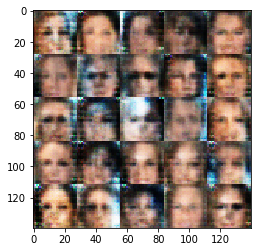

Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.5932... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.6393... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.6208


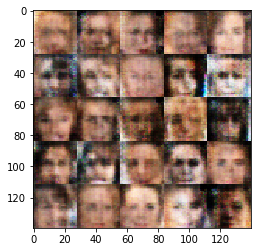

Epoch 1/1... Discriminator Loss: 1.5910... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.5728... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.6867


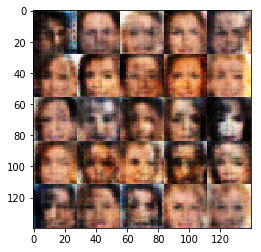

Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.6611


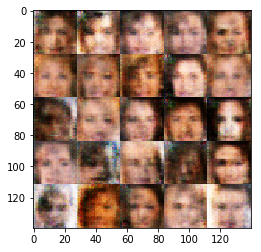

Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.5900... Generator Loss: 0.5758


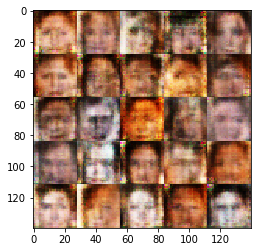

Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.5092
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6165


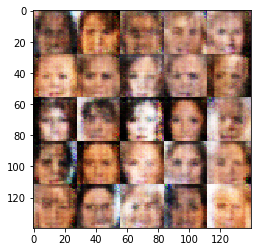

Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.5439... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.6318


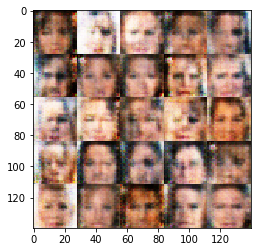

Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.5576... Generator Loss: 0.6161


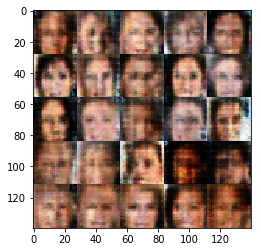

Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.6749


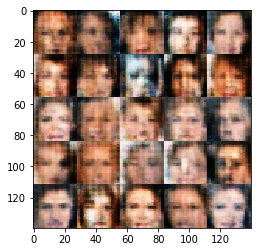

Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6794


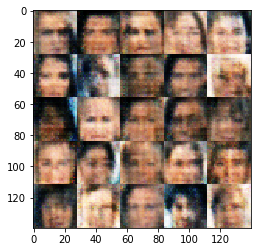

Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6378


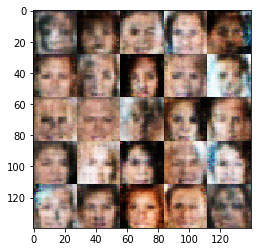

Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.6426... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.5898


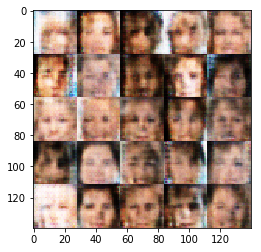

Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.5308... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.5899... Generator Loss: 0.6249


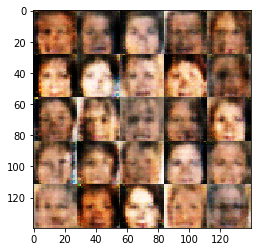

Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.5748


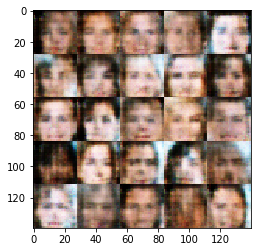

Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.6238


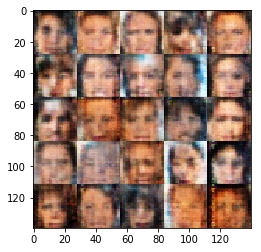

Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5489


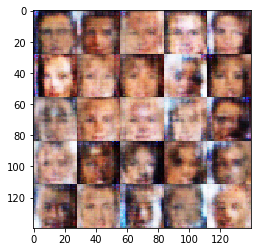

Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6881


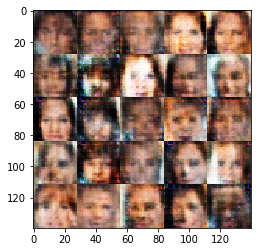

Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.6716


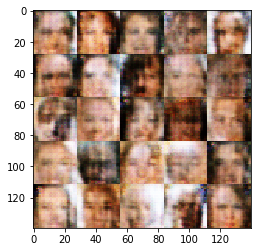

Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.6426


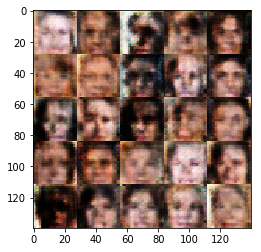

Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.5287... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6782


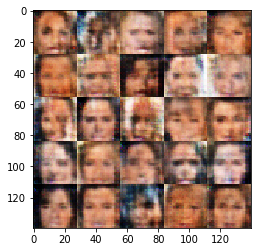

Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6951


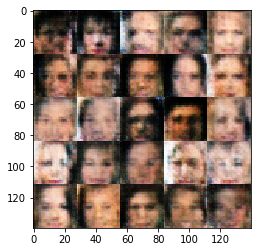

Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.5761


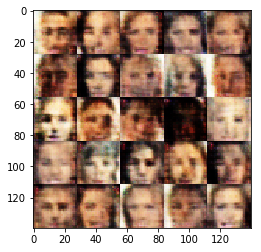

Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.5476


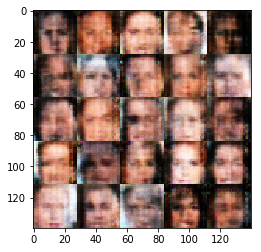

Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6491


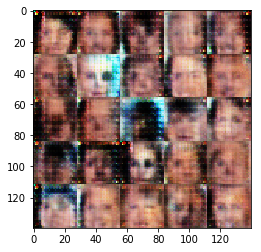

Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.5920... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.7525... Generator Loss: 1.3403
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.3794
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 0.7521


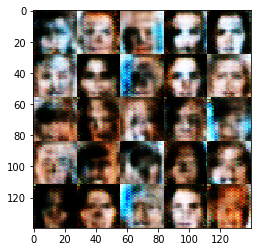

Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 1.6585
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.6039... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.6311... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.7064


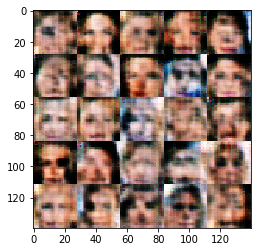

Epoch 1/1... Discriminator Loss: 1.6380... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 0.3548... Generator Loss: 1.8730
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.6188
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 1.1368
Epoch 1/1... Discriminator Loss: 2.4976... Generator Loss: 0.1054


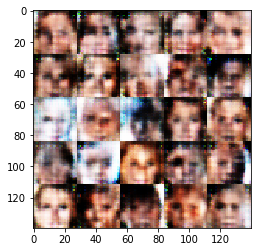

Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 1.4037
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.6899... Generator Loss: 0.3932
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.6034


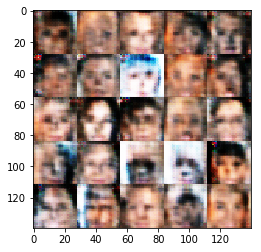

Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.5441
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.5805


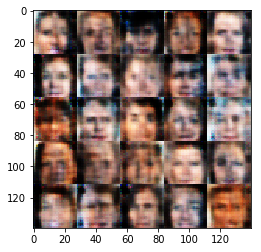

Epoch 1/1... Discriminator Loss: 1.6124... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.5252


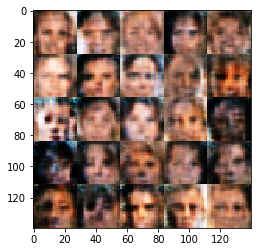

Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.5648... Generator Loss: 0.4347
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 0.9058


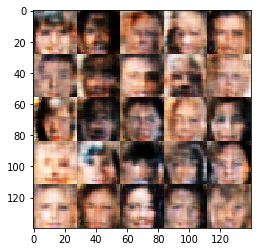

Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.4681
Epoch 1/1... Discriminator Loss: 1.7366... Generator Loss: 1.1750
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.5662


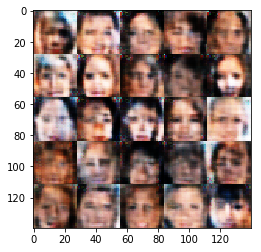

Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.5695... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6596


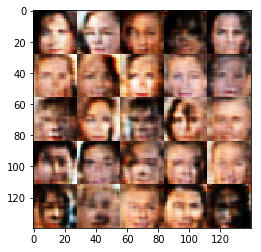

Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.8273


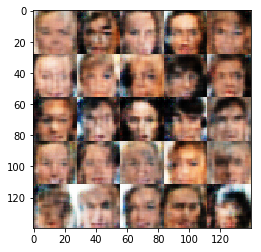

Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.6105


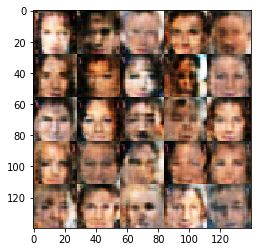

Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.6732


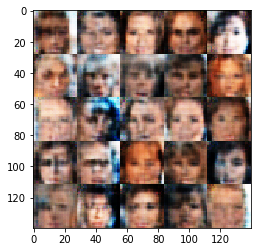

Epoch 1/1... Discriminator Loss: 1.5525... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.9406... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6696


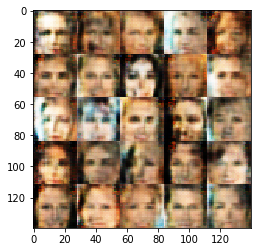

Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.5850
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6369


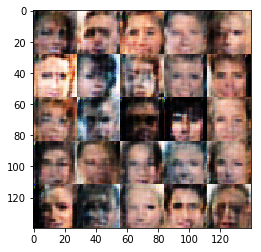

Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.5696


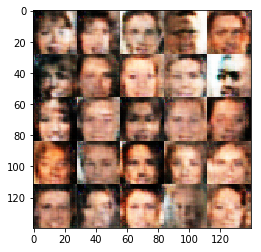

Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.5950


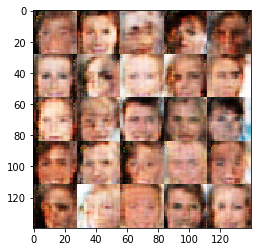

Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.6927


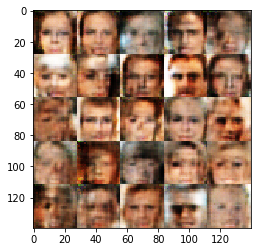

Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.3532
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.9845


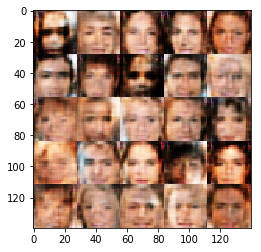

Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.5465... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.5844


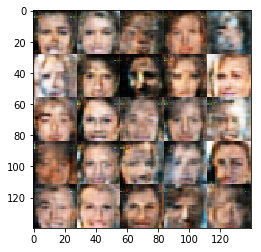

Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.5518


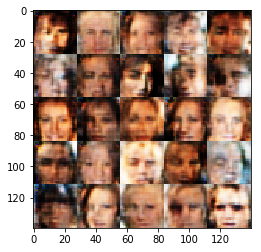

Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.6283... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.6994


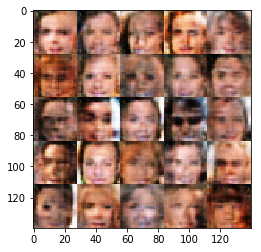

Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.6104... Generator Loss: 0.5508


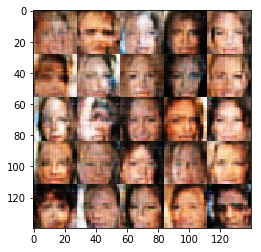

Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.6238... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.5818... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.5916


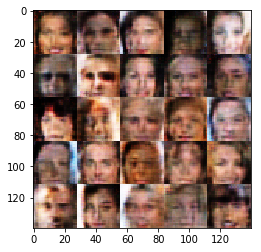

Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.5940


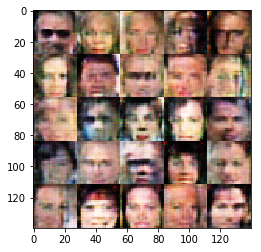

Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.6772


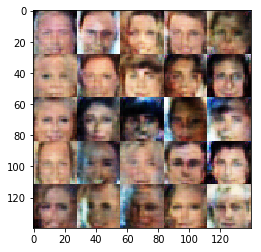

Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.5686


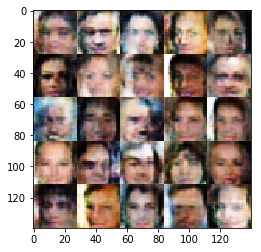

Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6919


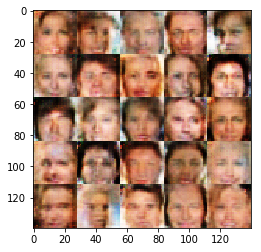

Epoch 1/1... Discriminator Loss: 1.5938... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.5759... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6096


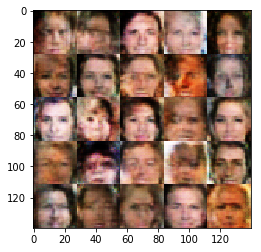

Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.5927


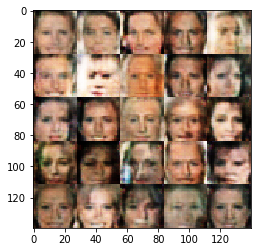

Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 0.6109... Generator Loss: 1.2774
Epoch 1/1... Discriminator Loss: 1.6576... Generator Loss: 0.4619
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.6119


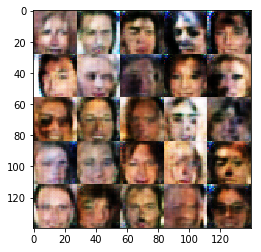

Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7023


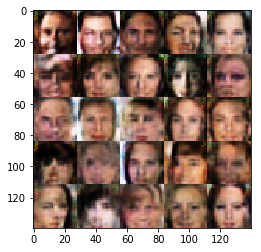

Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.7162... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6089


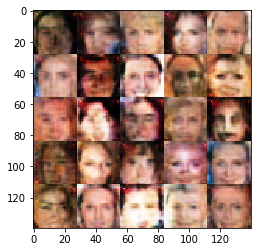

Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.5893


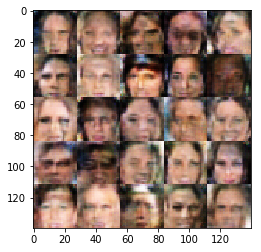

Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.5922


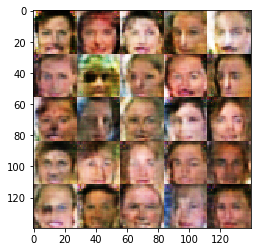

Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.5942
Finished training


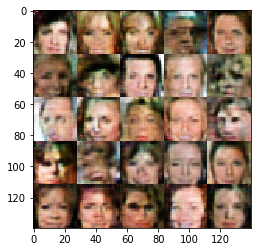

In [19]:
batch_size = 32
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.